In [19]:
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
from io import StringIO
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import statsmodels.api as sm
from statsmodels.tools import add_constant
import numpy as np
from statsmodels.base.model import LikelihoodModel
from statsmodels.regression.linear_model import OLS
from statsmodels.multivariate.manova import MANOVA
from statsmodels.multivariate.multivariate_ols import _MultivariateOLS
import statsmodels.multivariate.tests.results as path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
sys.path.append(r'\code')
from LinearRegDiagnostic import LinearRegDiagnostic
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import load_model

In [4]:
'''DATA-SCRAPING
    Uploaded data to GitHup Repository
    Scraped the data from raw'''

# Raw URL of the Markdown file
url ='https://raw.githubusercontent.com/osman-mohmmed/aibas/refs/heads/main/data/telecom_arpu_data.md'

# Step 1: Fetch the Markdown content
response = requests.get(url)
response.raise_for_status()
md_content = response.text

# Step 2: Manually process the Markdown table
# Split the content into lines
lines = md_content.splitlines()

# Find the start of the table (look for |---|)
table_start = -1
for i, line in enumerate(lines):
    if '|---' in line:
        table_start = i - 1  # Header is the line before this
        break

if table_start == -1:
    print("No table found in the Markdown file.")
else:
    # Extract the table lines
    table_lines = lines[table_start:]
    table_text = "\n".join(table_lines)

    # Use pandas to parse the table
    df = pd.read_csv(StringIO(table_text), sep="|").iloc[:, 1:-1]  # Trim empty columns
  
df.describe()


C:\Users\o.eltahir\AppData\Local\Temp\ipykernel_20176\476622216.py:32: DtypeWarning: Columns (1,2,10,11,12,13,82,83,84,85,122,123,124,125,138,139,140,141,142,143,144,145,146,147,148,149,154,155,156,157,182,183,184,185,186,187,188,189,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,222,223,224,225,226) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(table_text), sep="|").iloc[:, 1:-1]  # Trim empty columns


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,22999,22999,22999,22999,22999,22999,22999,22999,22999,22999.0,...,22999,22999,22999,22999,22999,22999,22999.0,22999.0,22999.0,22999.0
unique,22999,3,3,3,3,2,3,3,3,21502.0,...,31,4,4,4,4,5026,3708.0,3568.0,3408.0,1135.0
top,----------------:,109,0,0,0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,...,0,nan,nan,nan,nan,3651,0.0,0.0,0.0,0.0
freq,1,18903,22769,22769,22769,22998,22850,22737,22605,690.0,...,18110,17154,17118,16935,17036,253,15781.0,15882.0,16053.0,17904.0


In [5]:
''' Preprocessing:
    1-DATA-CLEANING 
        -Null values handelling :
            -replace 'nan' aith np.nan.
            -droped columns with 10k nulls & droped rows with null values.'''



df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.columns = df.columns.str.strip()
#delete noisy chacters ':----'
df.drop(df[df['mobile_number'] == '----------------:'].index,inplace= True)

# Remove null values with a threshold

df = df.replace(['NaN', 'nan', 'null', '', None], np.nan, regex=True)
null_counts = df.isnull().sum()
threshold = 10000
df = df.loc[:, df.isnull().sum() <= threshold]
print(null_counts)

#drop rows with null values
df = df.dropna()
df.describe()


C:\Users\o.eltahir\AppData\Local\Temp\ipykernel_20176\560988346.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


mobile_number       0
circle_id           0
loc_og_t2o_mou    229
std_og_t2o_mou    229
loc_ic_t2o_mou    229
                 ... 
aon                 0
aug_vbc_3g          0
jul_vbc_3g          0
jun_vbc_3g          0
sep_vbc_3g          0
Length: 226, dtype: int64


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,19280,19280,19280,19280,19280,19280,19280,19280,19280,19280.0,...,19280,19280,19280,19280,19280,19280,19280.0,19280.0,19280.0,19280.0
unique,19280,2,1,1,1,1,1,1,1,18669.0,...,14,27,28,27,28,4848,3376.0,3183.0,2983.0,1082.0
top,7001865778,109,0,0,0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.0,...,0,0,0,0,0,3651,0.0,0.0,0.0,0.0
freq,1,15816,19280,19280,19280,19280,19280,19280,19280,201.0,...,14725,15147,15155,15100,15079,228,12979.0,13137.0,13328.0,14871.0


In [6]:
'''Data type '''
#drop date columns
df.drop(['last_date_of_month_9','last_date_of_month_8','last_date_of_month_7','last_date_of_month_6'], axis=1, inplace = True )
df.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9'], axis = 1, inplace=True)

#drop id columns
df.drop(['mobile_number','circle_id'], axis=1, inplace=True) 

#convert to numeric
df = df.apply(pd.to_numeric)

df.dtypes


loc_og_t2o_mou      int64
std_og_t2o_mou      int64
loc_ic_t2o_mou      int64
arpu_6            float64
arpu_7            float64
                   ...   
aon                 int64
aug_vbc_3g        float64
jul_vbc_3g        float64
jun_vbc_3g        float64
sep_vbc_3g        float64
Length: 176, dtype: object

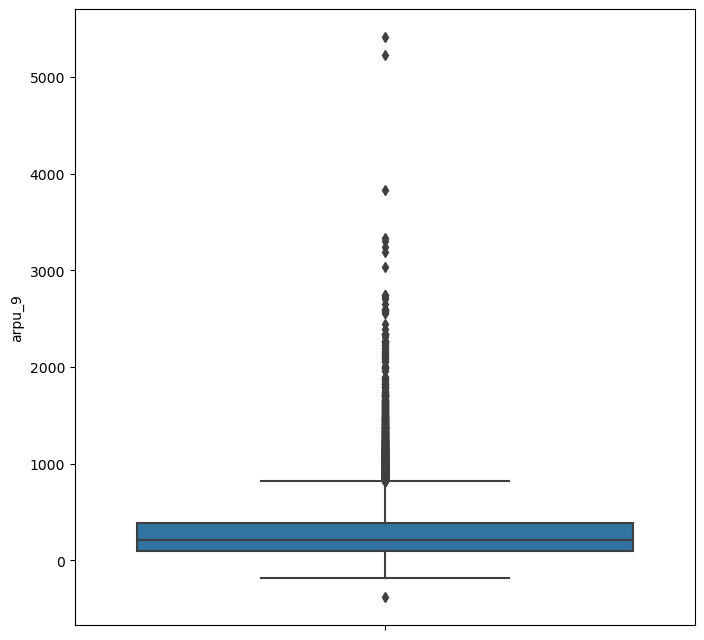

In [9]:
'''Data visualisation:
    boxplot of lable column'''
plt.figure(figsize=(8,8))
sns.boxplot( y = 'arpu_9', data = df) 

plt.savefig('../results/images/DP_boxplot_before.png')

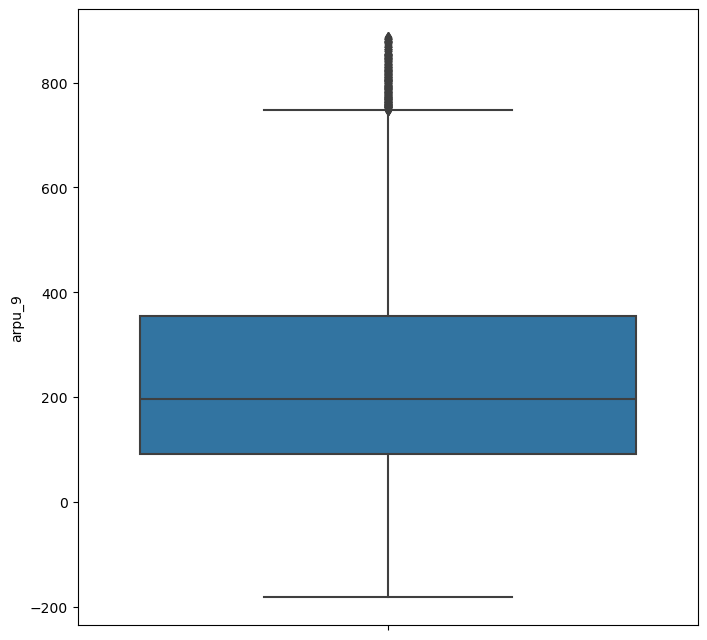

In [10]:
#detect and remove outliers with zscores
zs = stats.zscore(df['arpu_9'])
zs_ind = abs(zs) < 2
df_filtered = df[zs_ind]
plt.figure(figsize=(8,8))
sns.boxplot( y = 'arpu_9', data = df_filtered) 
plt.savefig('../results/images/DP_boxplot_after.png')

In [30]:
# Define the split ratio
split_ratio = 0.8

# Split index
split_index = int(len(df_filtered) * split_ratio)

# Split data
train_df = df_filtered[:split_index]
test_df = df_filtered[split_index:]

#
lable = df_filtered['arpu_9']
features = df_filtered.drop('arpu_9', axis=1)

X_train = train_df[features.columns] 
X_test = test_df[features.columns] 
y_train = train_df['arpu_9']
y_test = test_df['arpu_9']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14744, 175)
(3687, 175)
(14744,)
(3687,)


In [38]:
v = train_df.iloc[100,:]
print(v)

loc_og_t2o_mou      0.000
std_og_t2o_mou      0.000
loc_ic_t2o_mou      0.000
arpu_6            238.504
arpu_7             65.150
                   ...   
aon               885.000
aug_vbc_3g          0.000
jul_vbc_3g          0.000
jun_vbc_3g          0.000
sep_vbc_3g          0.000
Name: 133, Length: 176, dtype: float64


In [31]:
'''Modeling
    1| OLS Model'''

# lable = df_filtered['arpu_9']
# features = df_filtered.drop('arpu_9', axis=1)


# X_train, X_test, y_train, y_test = train_test_split(df_filtered[features.columns], df_filtered['arpu_9'] , 
#                                    random_state=104,  
#                                    test_size=0.20,  
#                                    shuffle=True)

# X_train.to_csv("../data/dataset_feature_training.csv")
# X_test.to_csv("../data/dataset_feature_testing.csv")

# y_train.to_csv("../data/dataset_lable_training.csv")
# y_test.to_csv("../data/dataset_lable_testing.csv")

#OLS model

X = add_constant(X_train)
Y = y_train

ols_m = sm.OLS(Y,X).fit()

# ols_m.save('../results/models/OLS_model.pickle')


print(ols_m.summary())

                            OLS Regression Results                            
Dep. Variable:                 arpu_9   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1265.
Date:                Mon, 27 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:17:30   Log-Likelihood:                -79007.
No. Observations:               14744   AIC:                         1.583e+05
Df Residuals:                   14579   BIC:                         1.596e+05
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.4537      1

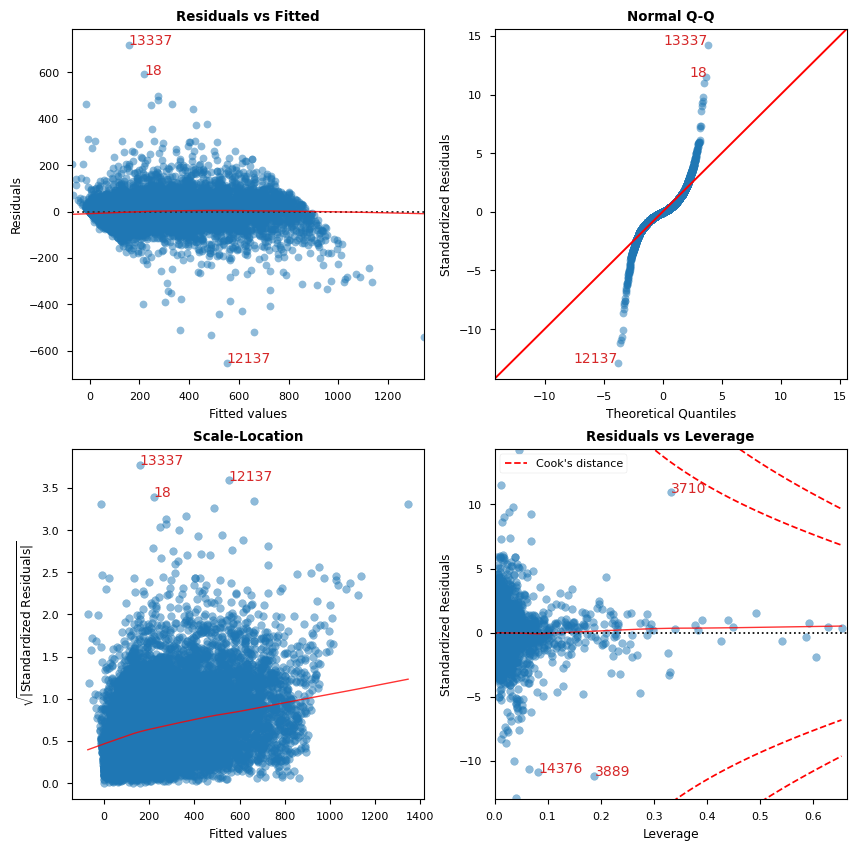

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


               Features  VIF Factor
175          sep_vbc_3g        1.13
171                 aon        1.27
146  last_day_rch_amt_9        1.47
170         sachet_3g_9        1.71
144  last_day_rch_amt_7        1.78
..                  ...         ...
58     std_og_t2c_mou_9         NaN
107    std_ic_t2o_mou_6         NaN
108    std_ic_t2o_mou_7         NaN
109    std_ic_t2o_mou_8         NaN
110    std_ic_t2o_mou_9         NaN

[176 rows x 2 columns]


In [32]:
'''OLS Model visualization
'''

cls = LinearRegDiagnostic(ols_m)
vif, fig, ax = cls()
# fig.savefig('../results/images/M_DiagnosticPlots.png')
print(vif)

In [ ]:
''''Modeling:
        ANN'''

input_feature = X_train.values  
target_feature = y_train.values  
test_target = y_test.values
test_feature = X_test.values
 
# Defining the TensorFlow feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (X_train.shape[1],)),# Input layer
    tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(1, activation= 'linear')  # Output layer with 1 neuron
])
 
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',  # Mean squared error
              metrics=['mae'])
 
# Training the model
model.fit(X_train, target_feature, epochs=50, batch_size=32, verbose=1)
 
 #Save model
model.save('../results/models/ANN_model.keras')

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, test_target, verbose=0)
print(f"Test Loss: {loss}, Test MAE: {mae}")

Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 14084.4248 - mae: 76.5843
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4211.1943 - mae: 42.3414
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3585.5793 - mae: 38.7153
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3080.2046 - mae: 36.3988
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2834.9138 - mae: 34.9382
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2600.4165 - mae: 33.8951
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2587.1760 - mae: 33.7123
Epoch 8/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2716.5686 - mae: 34.1725
Epoch 9/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2411.6636 - mae: 32.0787
Epoch 10/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2255.4480 - mae: 31.2902
Epoch 11/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2369.4399 - mae: 32.0480
Epoch 12/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2

Test Loss: 3274.924072265625, Test MAE: 33.369998931884766


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step


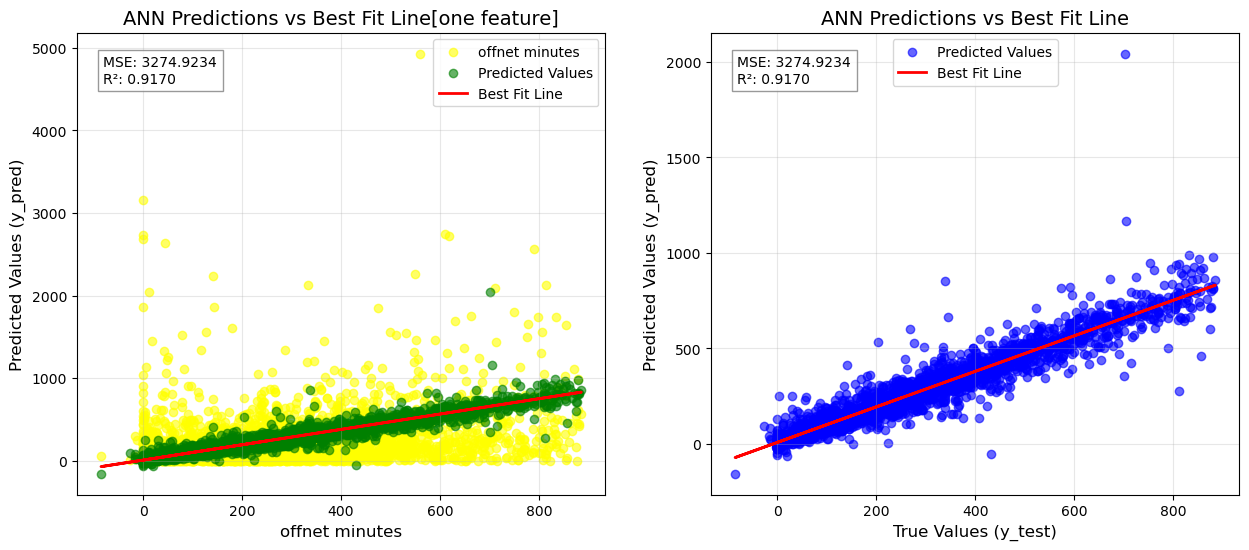

In [29]:
'''ANN Model Visualisation'''

# Generate predictions from the ANN model

y_pred = model.predict(X_test).flatten()  # Ensure predictions are 1D if needed
 
# Calculate best-fit line (y_pred as a function of y_test)

slope, intercept = np.polyfit(y_test, y_pred, 1)
 
# Create best-fit line

best_fit_line = slope * y_test + intercept
 
# Calculate performance metrics

mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
 
# Plot the results
plt.figure(figsize=(15, 6))


# plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Model Predictions')
plt.subplot(1,2,1)

# Plot actual values in one color (e.g., red)
plt.scatter(y_test, X_test['offnet_mou_6'], alpha=0.6, color='yellow', label='offnet minutes')
 # Plot predicted values in a different color (e.g., green)
plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='Predicted Values')

plt.plot(y_test, best_fit_line, color='red', linewidth=2, label='Best Fit Line')
 
# Add annotations

plt.title('ANN Predictions vs Best Fit Line[one feature]', fontsize=14)

plt.xlabel('offnet minutes', fontsize=12)

plt.ylabel('Predicted Values (y_pred)', fontsize=12)

plt.legend(fontsize=10)
 
# Display metrics

plt.text(

    0.05, 0.95,

    f"MSE: {mse:.4f}\nR²: {r2:.4f}",

    fontsize=10,

    transform=plt.gca().transAxes,

    verticalalignment='top',

    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')

)
 
plt.grid(alpha=0.3)

#second plot
plt.subplot(1,2,2)
# Plot actual values

plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predicted Values',  )

plt.plot(y_test, best_fit_line, color='red', linewidth=2, label='Best Fit Line')
 

# Add annotations

plt.title('ANN Predictions vs Best Fit Line', fontsize=14)

plt.xlabel('True Values (y_test)', fontsize=12)

plt.ylabel('Predicted Values (y_pred)', fontsize=12)

plt.legend(fontsize=10)
 
# Display metrics

plt.text(

    0.05, 0.95,

    f"MSE: {mse:.4f}\nR²: {r2:.4f}",

    fontsize=10,

    transform=plt.gca().transAxes,

    verticalalignment='top',

    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')

)
 
plt.grid(alpha=0.3)

plt.legend(loc = "upper center")

plt.savefig('../results/images/M_best_fit_line_scatter.png')

plt.show()

 